In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score,confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from ray.air import session 


In [115]:
def get_datas(csv_path):
    data = pd.read_csv(csv_path,index_col=None)
    
    # 特徴量とターゲット変数の分割,DFのvalueのみ抽出
    X = data.drop('dengue', axis=1).values  
    y = data['dengue'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    #numpy配列をtensolに変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    #TensorDatasetの作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    return train_dataset,train_loader,X_test_tensor,y_test_tensor
    

In [116]:
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6=nn.Linear(64,1)
        #self.dropout_1 = nn.Dropout(p=0.3)
        #self.dropout_2 = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout_2(x) 
        
        x = torch.relu(self.fc2(x))
        #x = self.dropout_2(x)
        
        x = torch.relu(self.fc3(x))
        #x = self.dropout_1(x)
        
        x = torch.relu(self.fc4(x))
        #x = self.dropout_1(x)

        x=torch.relu(self.fc5(x))
        
        x = torch.sigmoid(self.fc6(x))
        
        return x


In [117]:
def train_classification_nn(config, train_loader, input_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = BinaryClassificationNN(input_size).to(device)
    
    # 複数GPUの場合はDataParallelを使用
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    criterion = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            # デバイスにテンソルを移動
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Ray TuneのセッションAPIを使用して損失を報告
        session.report({"loss": running_loss / len(train_loader)})

In [118]:
def tune_nn(input_size, train_loader):
    train_loader = train_loader

    # 設定の修正: weight_decayの範囲を修正し、名前を修正
    config = {
        "lr": tune.loguniform(1e-7, 1e-1),  
        "epochs": tune.choice([300,400,500,600,700])
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=30,
        grace_period=1,
        reduction_factor=2
    )

    reporter = CLIReporter(metric_columns=["loss", "training_iteration"])

    result = tune.run(
        tune.with_parameters(train_classification_nn, train_loader=train_loader, input_size=input_size),
        resources_per_trial={"cpu": 1, "gpu": 0.5},
        config=config,
        num_samples=10,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final loss: {}".format(best_trial.last_result["loss"]))

    return best_trial.config


In [119]:
def optimized_nn(input_size, train_loader, best_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = BinaryClassificationNN(input_size).to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    epochs = best_config['epochs']
    lr = best_config['lr']
    
    criterion = nn.BCELoss()  # バイナリクロスエントロピー
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)

    losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # デバイスにテンソルを移動
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()

            # バッチごとの損失を累計
            running_loss += loss.item() * X_batch.size(0)

            # バッチごとの損失を表示
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # エポックごとの平均損失を計算
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} Completed, Average Loss: {epoch_loss:.4f}")

    # 学習曲線の表示
    plt.figure()
    plt.plot(range(1, epochs + 1), losses, marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return model


In [120]:
def optimized_nn_with_cv(input_size, train_dataset,n_splits=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f'Fold {fold+1}/{n_splits}')
        
        #データの分割
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False)
        
        #モデルの初期化
        model = BinaryClassificationNN(input_size).to(device)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        
        epochs = 20
        lr = 0.001
        
        criterion = nn.BCELoss()  
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
        
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            model.train()
            running_train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.float())
                loss.backward()
                optimizer.step()
                
                running_train_loss += loss.item() * X_batch.size(0)
            
            # エポックごとの平均トレーニング損失
            epoch_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            #検証
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, y_batch.float())
                    running_val_loss += val_loss.item() * X_batch.size(0)

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

            print(f"Fold {fold+1}, Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

    # 学習曲線
    avg_train_losses = [sum(fold_losses) / n_splits for fold_losses in zip(*fold_train_losses)]
    avg_val_losses = [sum(fold_losses) / n_splits for fold_losses in zip(*fold_val_losses)]

    plt.figure()
    plt.plot(range(1, epochs + 1), avg_train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), avg_val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss Curve with Cross-Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


In [121]:
def test_classification_nn(X_test_tensor, y_test_tensor, model,threshold=0.41):
    # デバイスの設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # モデルをデバイスに移動
    model.to(device)
    model.eval()  # 評価モード

    # テストデータをデバイスに移動
    X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

    with torch.no_grad():
        # 予測の取得
        predictions = model(X_test_tensor)
        predictions = (predictions >= threshold).float()

        # Accuracyの計算
        accuracy = (predictions == y_test_tensor).float().mean()
        print(f'Accuracy: {accuracy:.4f}')
        
        # テンソルをCPUに戻しnumpy配列に変換
        y_pred = predictions.cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()

        cm = confusion_matrix(y_true, y_pred)

        # 混同行列をプロット
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

        # Precision, Recall, F1スコアの計算
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

Fold 1/5
Fold 1, Epoch 1/20 - Train Loss: 3.3170, Val Loss: 0.8597
Fold 1, Epoch 2/20 - Train Loss: 0.7346, Val Loss: 0.6458
Fold 1, Epoch 3/20 - Train Loss: 0.6349, Val Loss: 0.6077
Fold 1, Epoch 4/20 - Train Loss: 0.6431, Val Loss: 0.6065
Fold 1, Epoch 5/20 - Train Loss: 0.6157, Val Loss: 0.6069
Fold 1, Epoch 6/20 - Train Loss: 0.6258, Val Loss: 0.6082
Fold 1, Epoch 7/20 - Train Loss: 0.6158, Val Loss: 0.6060
Fold 1, Epoch 8/20 - Train Loss: 0.6164, Val Loss: 0.6047
Fold 1, Epoch 9/20 - Train Loss: 0.6209, Val Loss: 0.6021
Fold 1, Epoch 10/20 - Train Loss: 0.6078, Val Loss: 0.5927
Fold 1, Epoch 11/20 - Train Loss: 0.6266, Val Loss: 0.6603
Fold 1, Epoch 12/20 - Train Loss: 0.6356, Val Loss: 0.6077
Fold 1, Epoch 13/20 - Train Loss: 0.6186, Val Loss: 0.5974
Fold 1, Epoch 14/20 - Train Loss: 0.6069, Val Loss: 0.6002
Fold 1, Epoch 15/20 - Train Loss: 0.6051, Val Loss: 0.5976
Fold 1, Epoch 16/20 - Train Loss: 0.6047, Val Loss: 0.5940
Fold 1, Epoch 17/20 - Train Loss: 0.6087, Val Loss: 0.59

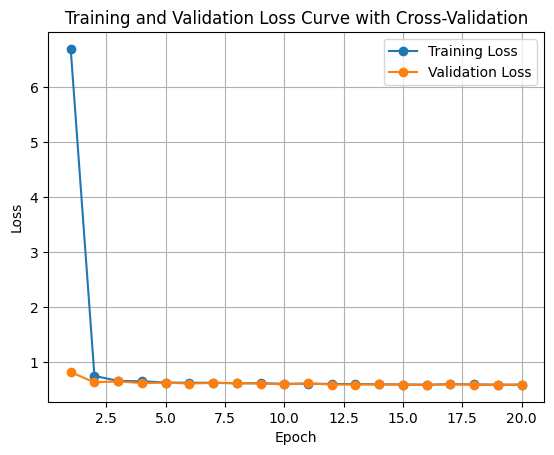

In [122]:
train_dataset,train_loader,X_test_tensor,y_test_tensor=get_datas('../../data/learning_data.csv')
input_size=X_test_tensor.shape[1]

#best_config=tune_nn(input_size,train_loader)
#print(best_config)
model=optimized_nn_with_cv(input_size,train_dataset)

Accuracy: 0.7327


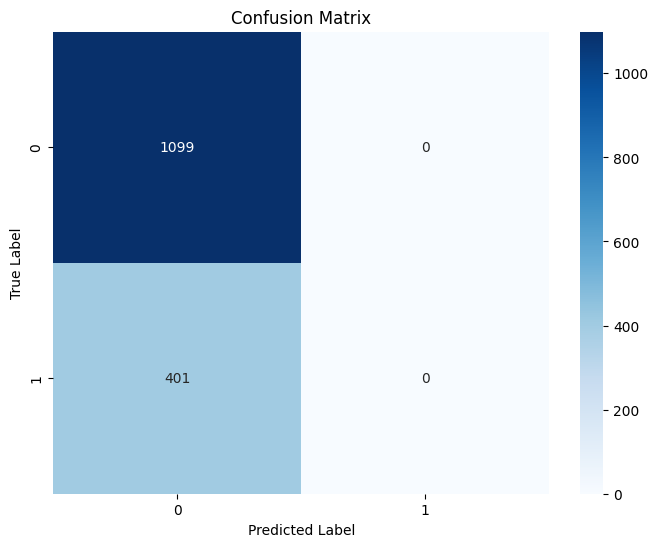

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
test_classification_nn(X_test_tensor,y_test_tensor,model)